<a href="https://colab.research.google.com/github/r7sy/SuttonBarto-RL2018-Sols/blob/master/Chapter%2004/Jack's_Car_Rental_Policy_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Jack's Car Rental : Policy iteration
This notebook recreates figure 4.2 from "Reinforcement Learning an Introduction second edition" by Richard S. Sutton and Andrew G. Barto. It also contains the solution to exercise 4.7 ; The problem is defined in the book as follows:
>Example 4.2: Jack’s Car Rental Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited \\$10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of \$2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is n is $\frac{\lambda^n}{n!}e^-\lambda$, where $\lambda$ is the expected number. Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be  $\gamma=0.9$ and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.

The notebook implements the Policy Iteration algorithm described on page 80 of the book to solve this problem. At first we recreate figure 4.2 from the book, afterwards we apply policy iteration for the revised problem described in exercise 4.7

In [0]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Initializing the problem's parameters.
max_cars_first_location=20
max_cars_second_location=20
rented_car_reward=10
car_moved_penalty=2
maximum_moves_allowed=5
# Lambda values for the Poisson distributions.
first_location_requests_lam=3
second_location_requests_lam=4
first_location_returns_lam=3
second_location_returns_lam=2

# Initializing the policy and value estimate for each state.

state_values=np.zeros(shape=(max_cars_first_location+1,max_cars_second_location+1))
policy=np.zeros(shape=(max_cars_first_location+1,max_cars_second_location+1))



# Possible requests from and returns to each location.
possible_requests_first=range(0,max_cars_first_location+1)
possible_requests_second=range(0,max_cars_second_location+1)
possible_returns_first=range(0,max_cars_first_location+1)
possible_returns_second=range(0,max_cars_second_location+1)

# Since model dynamics are the same across all states and timesteps, we compute 
# them beforehand. model_dynamics[l,m,n,o] holds the probability of receiving  
# l,m requests from the first and second locations respectively and having
# n,o cars returned to the first and second locations respectively.

model_dynamics=np.zeros(shape=(len(possible_requests_first),
                               len(possible_requests_second),
                               len(possible_returns_first),
                               len(possible_returns_second)))

for l,m,n,o in  np.ndindex(model_dynamics.shape):
  pl=(np.math.pow(first_location_requests_lam,l)/np.math.factorial(l))*np.math.exp(-first_location_requests_lam)
  pm=(np.math.pow(second_location_requests_lam,m)/np.math.factorial(m))*np.math.exp(-second_location_requests_lam)
  pn=(np.math.pow(first_location_returns_lam,n)/np.math.factorial(n))*np.math.exp(-first_location_returns_lam)
  po=(np.math.pow(second_location_returns_lam,o)/np.math.factorial(o))*np.math.exp(-second_location_returns_lam)
  if min(pl,pm,pn,po)>.000001:
    prob=pl*pm*pn*po
    model_dynamics[l,m,n,o]=prob

# Consider only the combinations of requests and returns that have a probability 
# greater than 0.00001 in the model_dynamics

possible_combinations=np.where(model_dynamics>.0)
possible_requests_first=possible_combinations[0]
possible_requests_second=possible_combinations[1]
possible_returns_first=possible_combinations[2]
possible_returns_second=possible_combinations[3]


In [0]:
def policyEvaluation(state_values,policy,gamma=0.9,threshold=0.0001):
  """Calculates state values for a given policy for jack's car rental problem.
  
  The function calculates the given policy's value function for jack's car rental
  problem as described in page 81 of the book, the values are calculated using 
  value iteration which is a dynamic programming algorithm for calculating the
  value function Vπ(S) for any given policy π.
  Parameters
  ----------
  state_values : array holding current state value function.
  policy : array holding the policy π to evaluate.
  gamma : value of the discounting factor.
  threshold : the threshold that stops the iteration.  
  """
  delta=float("inf")
  # Loop until the maximum absolute change of a state's value is lower than the threshold 
  while delta>threshold:
    delta=0.0
    # Loop over all states.
    for i,j in np.ndindex(state_values.shape):
      new_value=0.0
      
      # Take an action according to the policy.
      action=int(policy[i,j])
      action_penalty=np.abs(action) * -car_moved_penalty
      intermediate_state=(i-action,j+action)
      
      # Loop over possible combinations of requests and returns according to
      # the model dynamics to determine the probability of transitioning to every  
      # possible state in order to calculate the new value of state i,j 
      for k in range(len(possible_requests_first)):
          l=possible_requests_first[k]
          m=possible_requests_second[k]
          n=possible_returns_first[k]
          o=possible_returns_second[k]
          next_state=(min(max(intermediate_state[0]-l,0)+n,max_cars_first_location)
                      ,min(max(intermediate_state[1]-m,0)+o,max_cars_second_location))
          prob=model_dynamics[l,m,n,o]
          
          reward=(min(l,intermediate_state[0])+min(m,intermediate_state[1]))*rented_car_reward + action_penalty
          new_value+=prob*(reward+gamma*state_values[next_state])
              
      delta=max(delta,np.abs(new_value-state_values[i,j]))
      state_values[i,j]=new_value
        
      
    print("Max absolute change in state values is {}".format( delta))
   

      

In [0]:

def policyImprovment(state_values,policy,gamma=0.9):
  """Performs policy improvement for a given policy and its state values for 
     jack's car rental problem.
  
  The function performs policy improvement over the given policy and its value 
  function value function for jack's car rental problem as described in page 81
  of the book, the policy is improved according to the pseudo code described in
  page 80.
  
  Parameters
  ----------
  state_values : array holding current state value function.
  policy : array holding the policy π to improve.
  gamma : value of the discounting factor.
  """
  policy_stable=True
  
  # Loop over all states.
  for i,j in np.ndindex(state_values.shape):
      
      # Save the action taken under the previous policy.
      old_action=policy[i,j]
      max_return=0.0
      
      # Determine all possible actions from state i,j
      possible_actions=range(-min(j,max_cars_first_location-i,maximum_moves_allowed)
                             ,min(i,max_cars_second_location-j,maximum_moves_allowed)+1)
      
      # Loop over all possible actions
      for action in possible_actions:
        
        action_value=0
        action_penalty=np.abs(action) * -car_moved_penalty
        intermediate_state=(i-action,j+action)
        
        # Loop over possible combinations of requests and returns according to
        # the model dynamics to determine the probability of transitioning to   
        # every possible state in order to calculate the new value of state i,j 
        for k in range(len(possible_requests_first)):
          l=possible_requests_first[k]
          m=possible_requests_second[k]
          n=possible_returns_first[k]
          o=possible_returns_second[k]
          next_state=(min(max(intermediate_state[0]-l,0)+n,max_cars_first_location)
                      ,min(max(intermediate_state[1]-m,0)+o,max_cars_second_location))
          prob=model_dynamics[l,m,n,o]
          reward=(min(l,intermediate_state[0])+min(m,intermediate_state[1]))*rented_car_reward+ action_penalty
          action_value+=prob*(reward+gamma*state_values[next_state])
          
          
        if max_return<action_value:
          max_return=max(max_return,action_value)
          # If the state's value after taking the current action has a better 
          # return than the current state value, change the policy.
          if max_return>state_values[i,j]+.0000000001:
            policy[i,j]=action
      # If the policy was changed set policy_stable to false to indicate that
      # policy iteration should continue
      if policy[i,j]!=old_action:
        policy_stable=False
        
      
        
  return policy_stable
         

In [5]:
policies=[]
policies.append(np.copy(policy))
i=0
while True:
  i+=1
  policyEvaluation(state_values,policy)
  result=policyImprovment(state_values,policy)
  print("Finished iteration number {}".format(i))
  policies.append(np.copy(policy))
  if result:
    break

Max absolute change in state values is 193.34735973874734
Max absolute change in state values is 134.0026509929762
Max absolute change in state values is 90.450953825211
Max absolute change in state values is 67.59673960556975
Max absolute change in state values is 53.58386360431763
Max absolute change in state values is 41.71983367120015
Max absolute change in state values is 32.7191394803466
Max absolute change in state values is 26.086651680176942
Max absolute change in state values is 21.777314942193755
Max absolute change in state values is 18.317280482077933
Max absolute change in state values is 15.366683438364646
Max absolute change in state values is 12.860364190672499
Max absolute change in state values is 10.7386846050116
Max absolute change in state values is 8.94846182123041
Max absolute change in state values is 7.442643418033811
Max absolute change in state values is 6.179775199022913
Max absolute change in state values is 5.123516266552144
Max absolute change in state v

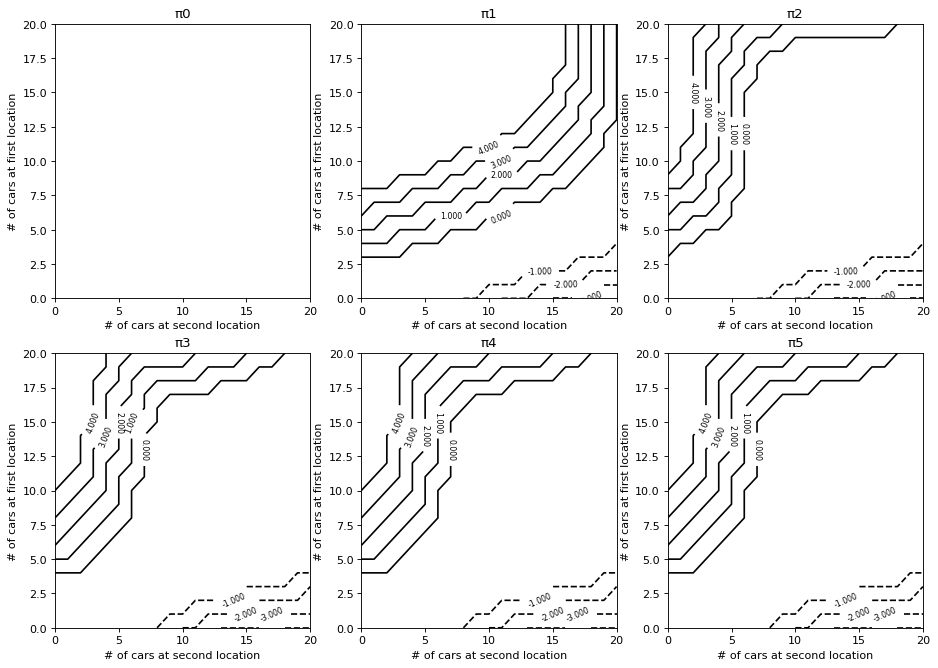

In [6]:
x = np.arange(0, max_cars_second_location+1, 1)
y = np.arange(0, max_cars_first_location+1, 1)
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
for i,policy_ in enumerate(policies):
  plt.subplot(np.math.ceil(len(policies)/3),3,i+1,)
  CS=plt.contour(x,y,policy_,levels=range(-4,5),colors='k')
  plt.clabel(CS, inline=1, fontsize=7)
  plt.xlabel("# of cars at second location")
  plt.ylabel("# of cars at first location")
  plt.title('π{}'.format(i));

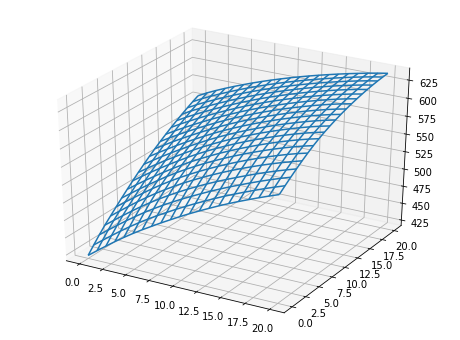

In [7]:
fig = plt.figure(figsize=(8,6))
X, Y = np.meshgrid(range(0,max_cars_second_location+1), range(0,max_cars_first_location+1))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, state_values, rstride=1, cstride=1)
plt.show()

The following cells implement policy iteration for the revised problem as described in the book :

>*Exercise 4.7 (programming)* Write a program for policy iteration and re-solve Jack’s car
rental problem with the following changes. One of Jack’s employees at the first location
rides a bus home each night and lives near the second location. She is happy to shuttle
one car to the second location for free. Each additional car still costs \\$2, as do all cars
moved in the other direction. In addition, Jack has limited parking space at each location.
If more than 10 cars are kept overnight at a location (after any moving of cars), then an
additional cost of \$4 must be incurred to use a second parking lot (independent of how
many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often
occur in real problems and cannot easily be handled by optimization methods other than
dynamic programming. To check your program, first replicate the results given for the
original problem$.$

In [0]:
# Initializing the policy and value estimate for each state.

state_values=np.zeros(shape=(max_cars_first_location+1,max_cars_second_location+1))
policy=np.zeros(shape=(max_cars_first_location+1,max_cars_second_location+1))


In [0]:
def revisedPolicyEvaluation(state_values,policy,gamma=0.9,threshold=0.0001):
  """Calculates state values for a given policy for jack's car rental problem.
  
  The function calculates the given policy's value function for the revised version
  of jack's car rental problem as described in exercise 4.7, the values are 
  calculated using value iteration which is a dynamic programming algorithm 
  for calculating the value function Vπ(S) for any given policy π.
  
  Parameters
  ----------
  state_values : array holding current state value function.
  policy : array holding the policy π to evaluate.
  gamma : value of the discounting factor.
  threshold : the threshold that stops the iteration.  
  """
  delta=float("inf")
  # Loop until the maximum absolute change of a state's value is lower than the threshold 
  while delta>threshold:
    delta=0.0
    # Loop over all states.
    for i,j in np.ndindex(state_values.shape):
      new_value=0.0
      
      # Take an action according to the policy.
      action=int(policy[i,j])
      action_penalty=np.abs(action - 1 if action>0 else action) * -car_moved_penalty
     
      intermediate_state=(i-action,j+action)
      
      # Loop over possible combinations of requests and returns according to
      # the model dynamics to determine the probability of transitioning to every  
      # possible state in order to calculate the new value of state i,j 
      for k in range(len(possible_requests_first)):
          l=possible_requests_first[k]
          m=possible_requests_second[k]
          n=possible_returns_first[k]
          o=possible_returns_second[k]
          next_state=(min(max(intermediate_state[0]-l,0)+n,max_cars_first_location)
                      ,min(max(intermediate_state[1]-m,0)+o,max_cars_second_location))
          additional_penalty=(int(next_state[0]>10) + int(next_state[1]>10))*-4
          prob=model_dynamics[l,m,n,o]
          
          reward=(min(l,intermediate_state[0])+\
                  min(m,intermediate_state[1]))*rented_car_reward +\
                  action_penalty + additional_penalty
          new_value+=prob*(reward+gamma*state_values[next_state])
              
      delta=max(delta,np.abs(new_value-state_values[i,j]))
      state_values[i,j]=new_value
        
      
    print("Max absolute change in state values is {}".format( delta))
   

      

In [0]:
def revisedPolicyImprovment(state_values,policy,gamma=0.9):
  """Performs policy improvement for a given policy and its state values for 
     the revised jack's car rental problem.
  
  The function performs policy improvement over the given policy and its value 
  function value function for the revised jack's car rental problem as described
  in exercise 4.7 of the book, the policy is improved according to the pseudo 
  code described in page 80.
  Parameters
  ----------
  state_values : array holding current state value function.
  policy : array holding the policy π to improve.
  gamma : value of the discounting factor.
  """
  policy_stable=True
  
  # Loop over all states.
  for i,j in np.ndindex(state_values.shape):
      
      # Save the action taken under the previous policy.
      old_action=policy[i,j]
      max_return=0.0
      
      # Determine all possible actions from state i,j
      possible_actions=range(-min(j,max_cars_first_location-i,maximum_moves_allowed)
                             ,min(i,max_cars_second_location-j,maximum_moves_allowed)+1)
      
      # Loop over all possible actions
      for action in possible_actions:
        
        action_value=0
        action_penalty=np.abs(action - 1 if action>0 else action) * -car_moved_penalty
        intermediate_state=(i-action,j+action)
        
        # Loop over possible combinations of requests and returns according to
        # the model dynamics to determine the probability of transitioning to   
        # every possible state in order to calculate the new value of state i,j 
        for k in range(len(possible_requests_first)):
          l=possible_requests_first[k]
          m=possible_requests_second[k]
          n=possible_returns_first[k]
          o=possible_returns_second[k]
          next_state=(min(max(intermediate_state[0]-l,0)+n,max_cars_first_location)
                      ,min(max(intermediate_state[1]-m,0)+o,max_cars_second_location))
          additional_penalty=(int(next_state[0]>10) + int(next_state[1]>10))*-4
          prob=model_dynamics[l,m,n,o]
          reward=(min(l,intermediate_state[0])+\
                  min(m,intermediate_state[1]))*rented_car_reward+\
                  action_penalty+additional_penalty
          action_value+=prob*(reward+gamma*state_values[next_state])
          
          
          if max_return<=action_value:
            max_return=max(max_return,action_value)
            
            # If the state's value after taking the current action has a better 
            # return than the current state value, change the policy.
            if max_return>state_values[i,j]:
              policy[i,j]=action
      # If the policy was changed set policy_stable to false to indicate that
      # policy iteration should continue
      if policy[i,j]!=old_action:
        policy_stable=False
        
      
        
  return policy_stable
         

In [8]:
policies=[]
policies.append(np.copy(policy))
i=0
while True:
  i+=1
  revisedPolicyEvaluation(state_values,policy)
  result=revisedPolicyImprovment(state_values,policy)
  print("Finished iteration number {}".format(i))
  policies.append(np.copy(policy))
  if result:
    break

Max absolute change in state values is 173.6228968778392
Max absolute change in state values is 121.98826514960186
Max absolute change in state values is 83.51217870654554
Max absolute change in state values is 65.62676463607497
Max absolute change in state values is 52.273726456389085
Max absolute change in state values is 40.73205042251129
Max absolute change in state values is 31.89800453455439
Max absolute change in state values is 25.368443169991224
Max absolute change in state values is 21.171321784938243
Max absolute change in state values is 17.74850866887823
Max absolute change in state values is 14.846467241989728
Max absolute change in state values is 12.39385930006955
Max absolute change in state values is 10.326758157651511
Max absolute change in state values is 8.589171611625432
Max absolute change in state values is 7.132350152967717
Max absolute change in state values is 5.913945472807654
Max absolute change in state values is 4.897276982964229
Max absolute change in st

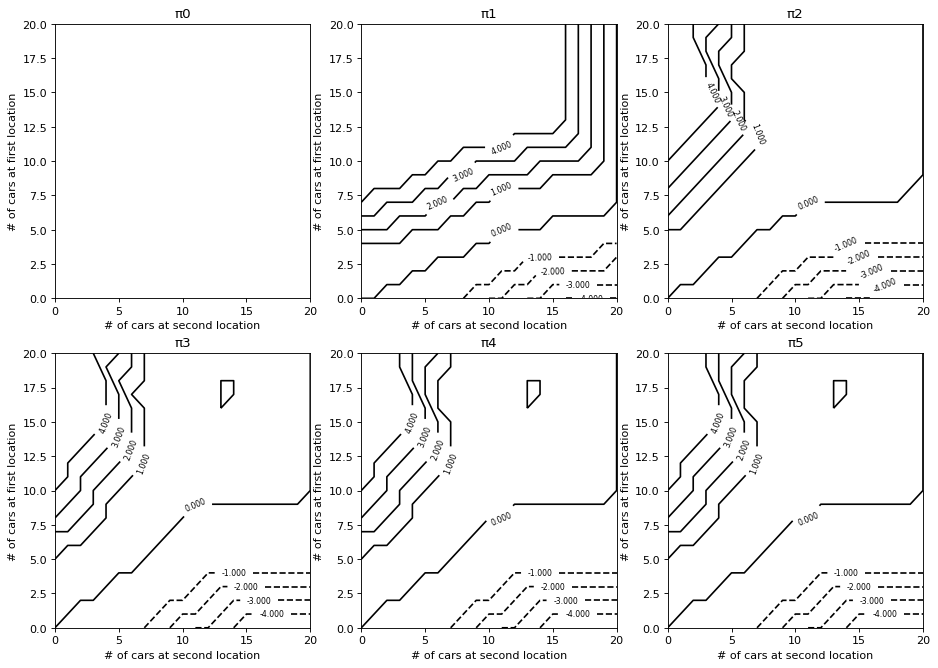

In [9]:
x = np.arange(0, max_cars_second_location+1, 1)
y = np.arange(0, max_cars_first_location+1, 1)
plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
for i,policy_ in enumerate(policies):
  plt.subplot(np.math.ceil(len(policies)/3),3,i+1,)
  CS=plt.contour(x,y,policy_,levels=range(-4,5),colors='k')
  plt.clabel(CS, inline=1, fontsize=7)
  plt.xlabel("# of cars at second location")
  plt.ylabel("# of cars at first location")
  plt.title('π{}'.format(i));

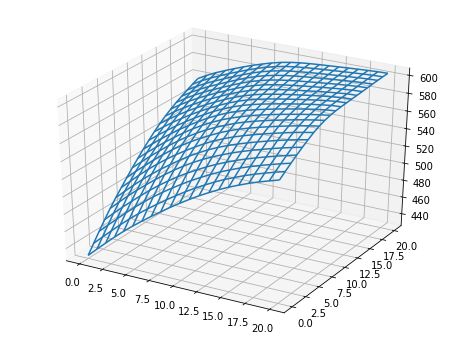

In [10]:
fig = plt.figure(figsize=(8,6))
X, Y = np.meshgrid(range(0,max_cars_second_location+1), range(0,max_cars_first_location+1))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, state_values, rstride=1, cstride=1)
plt.show()